### **Кластеризация**

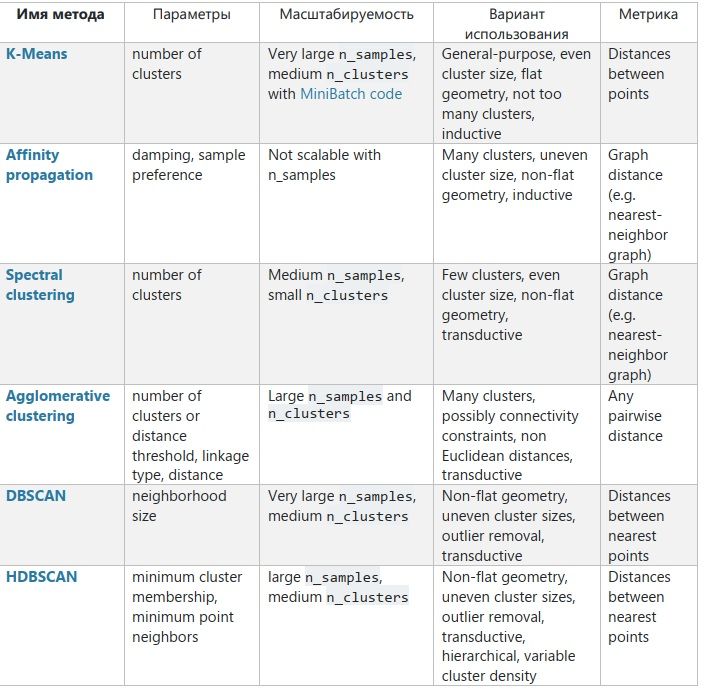

# **Генерация данных**

Функция make_blobsгенерирует изотропные гауссовы капли

In [ ]:
import numpy as np

from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)  # Anisotropic blobs
X_varied, y_varied = make_blobs( n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)  # Unequal variance
X_filtered = np.vstack(    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]) )  # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10

Визуализируем полученные данные:

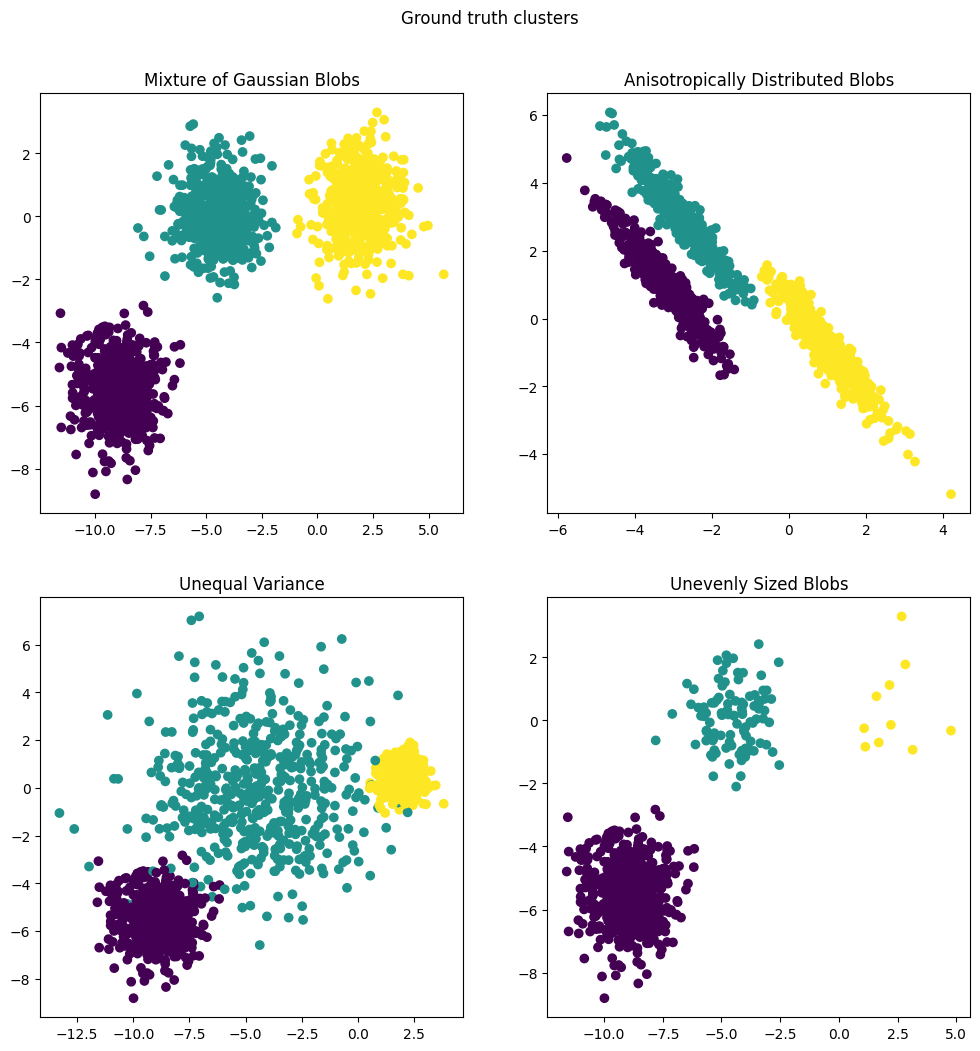

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axs[0, 0].set_title("Mixture of Gaussian Blobs")

axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[1, 0].set_title("Unequal Variance")

axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()

Неоптимальное количество кластеров:

Анизотропно распределенные капли:

Неравная дисперсия:

Капли неравномерного размера:

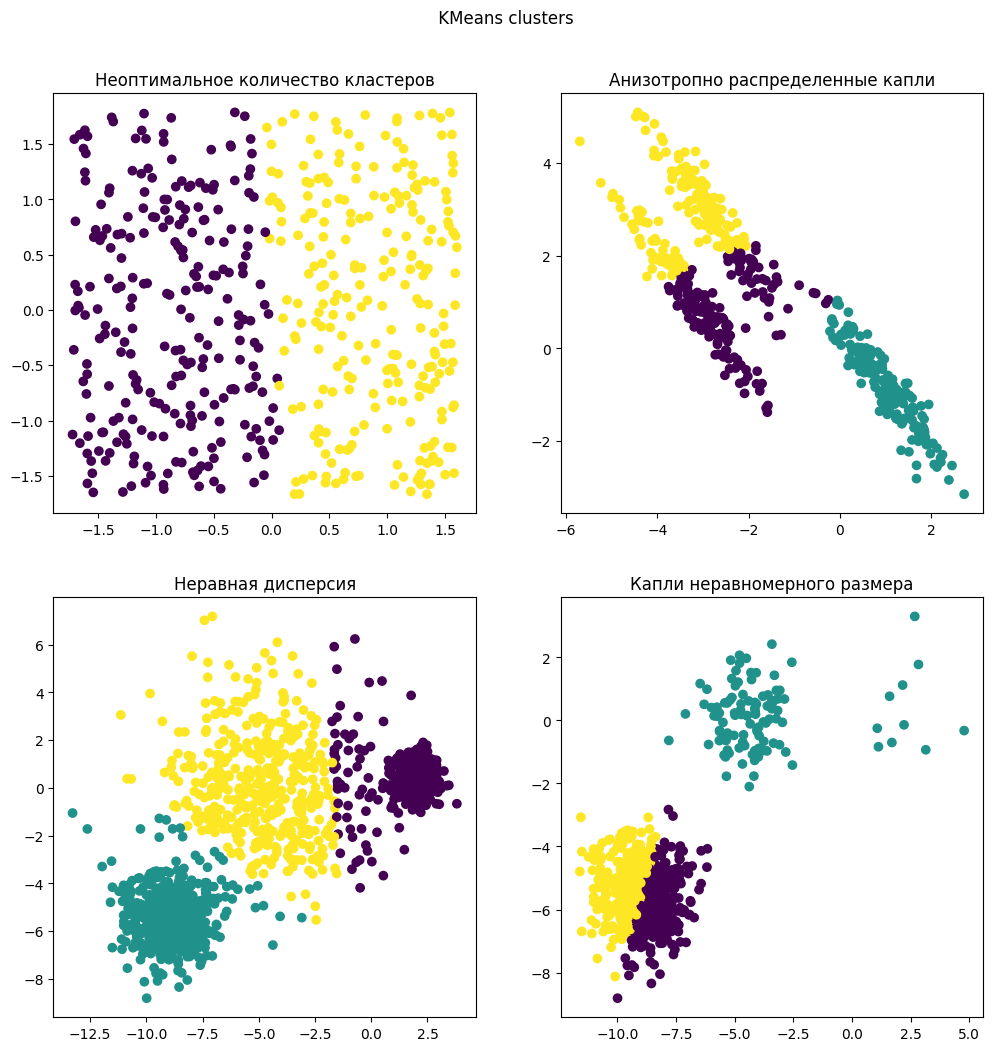

In [ ]:
from sklearn.cluster import KMeans

common_params = {
    "n_init": "auto",
    "random_state": random_state,
}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

y_pred = KMeans(n_clusters=2, **common_params).fit_predict(X)
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[0, 0].set_title("Неоптимальное количество кластеров")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_aniso)
axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
axs[0, 1].set_title("Анизотропно распределенные капли")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_varied)
axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
axs[1, 0].set_title("Неравная дисперсия")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_filtered)
axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
axs[1, 1].set_title("Капли неравномерного размера")

plt.suptitle(" KMeans clusters").set_y(0.95)
plt.show()

**Возможные решения**

Правильное количество кластеров)

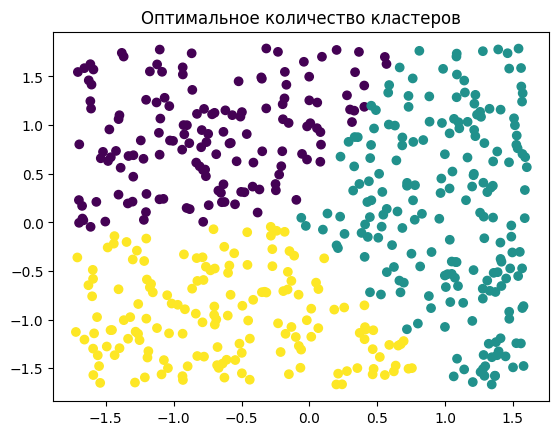

In [ ]:
y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Оптимальное количество кластеров")
plt.show()

Чтобы справиться с каплями неравномерного размера, можно увеличить количество случайных инициализаций. В этом случае  n_init=10 и стараемся избегать поиска неоптимального локального минимума

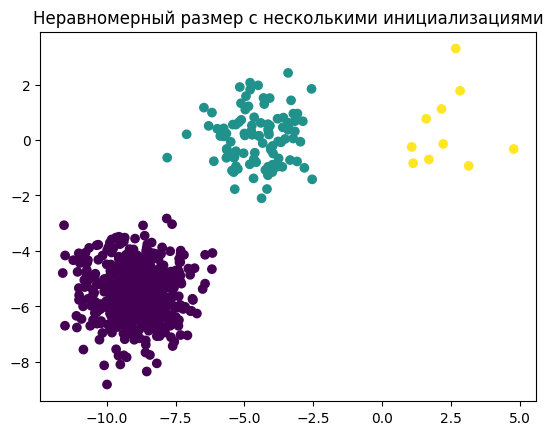

In [ ]:
y_pred = KMeans(n_clusters=3, n_init=10, random_state=random_state).fit_predict( X_filtered )
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Неравномерный размер с несколькими инициализациями")
plt.show()

Использовать GaussianMixture, который также предполагает гауссовы кластеры, но не накладывает никаких ограничений на их дисперсии

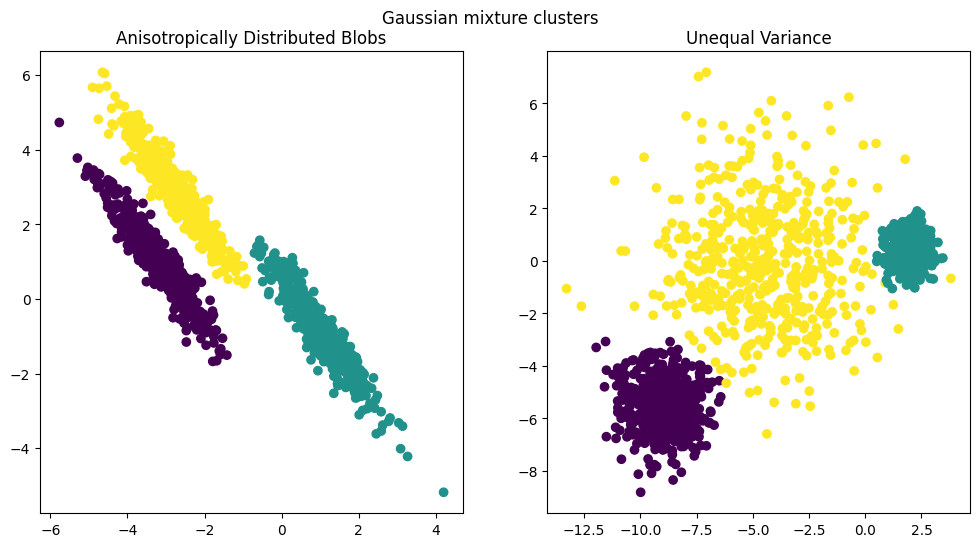

In [ ]:
from sklearn.mixture import GaussianMixture

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

y_pred = GaussianMixture(n_components=3).fit_predict(X_aniso)
ax1.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
ax1.set_title("Anisotropically Distributed Blobs")

y_pred = GaussianMixture(n_components=3).fit_predict(X_varied)
ax2.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
ax2.set_title("Unequal Variance")

plt.suptitle("Gaussian mixture clusters").set_y(0.95)
plt.show()

### **Сравнение различных алгоритмов кластеризации**

В этом примере показаны характеристики различных алгоритмов кластеризации на «интересных» наборах данных, но все еще в 2D. За исключением последнего набора данных, параметры каждой из этих пар набор данных-алгоритм были настроены для получения хороших результатов кластеризации. Некоторые алгоритмы более чувствительны к значениям параметров, чем другие.

Последний набор данных является примером «нулевой» ситуации для кластеризации: данные однородны, и хорошей кластеризации нет. В этом примере нулевой набор данных использует те же параметры, что и набор данных в строке над ним, что представляет собой несоответствие значений параметров и структуры данных.

Хотя эти примеры дают некоторое представление об алгоритмах, это представление может быть неприменимо к данным очень большой размерности.

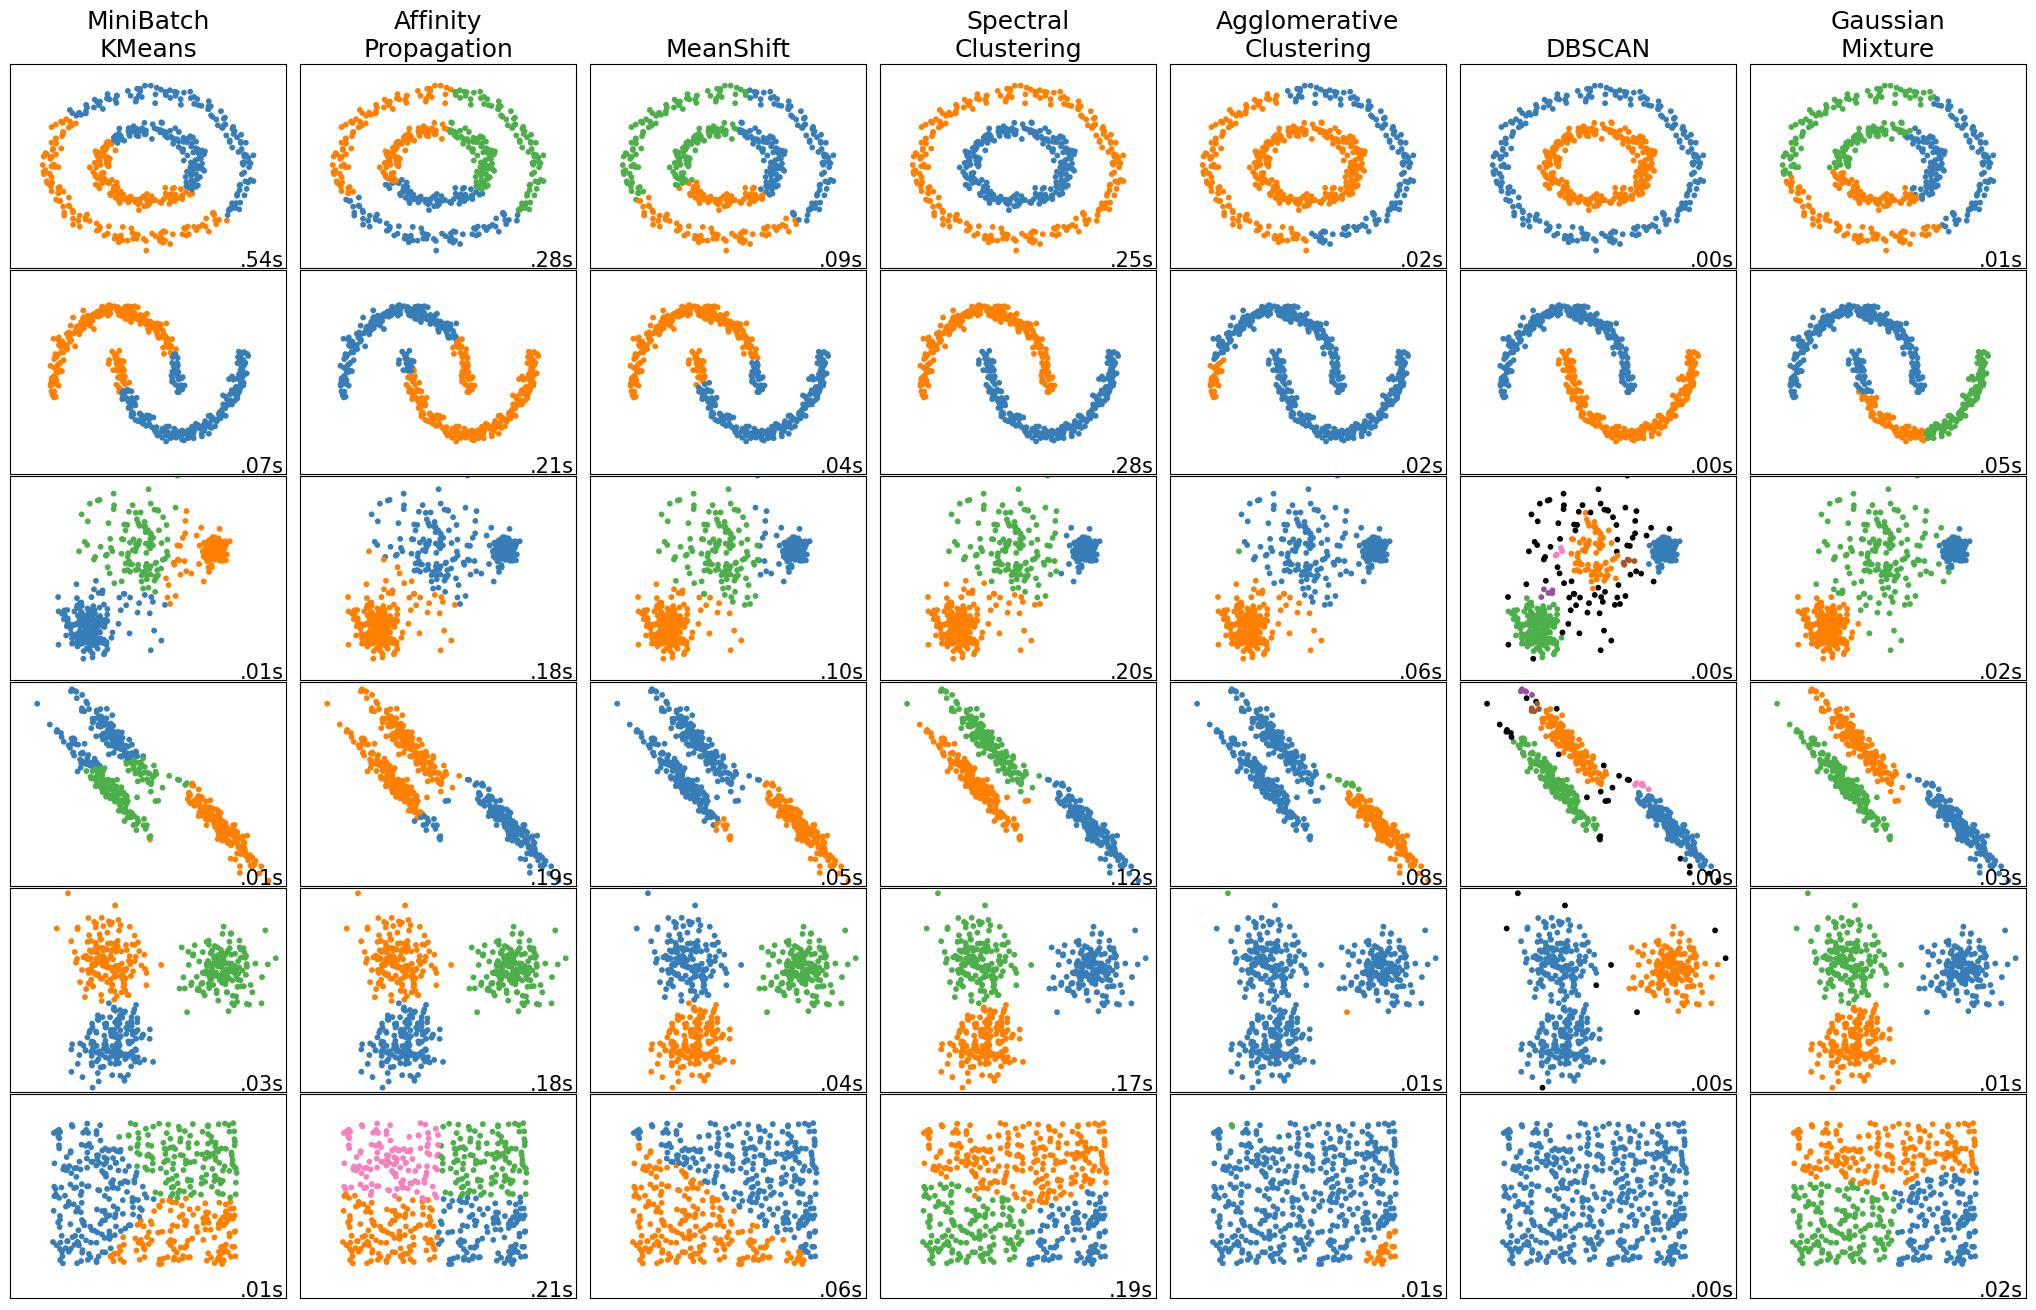

In [ ]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

# ============
# Генерация наборов данных. Мы выбираем размер, достаточно большой, чтобы увидеть масштабируемость.
#Количество алгоритмов, но не слишком большое, чтобы избежать слишком длительного времени работы.
# ============
n_samples = 500
seed = 30
noisy_circles = datasets.make_circles(
    n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed
)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Анизотропно распределенные данные
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# капли с различными отклонениями
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Настройка параметров кластера
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # обновить параметры значениями, специфичными для набора данных
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # нормализовать набор данных для облегчения выбора параметров
    X = StandardScaler().fit_transform(X)

    # оценить полосу пропускания для среднего сдвига
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # матрица связности для структурированного Уорда
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Создание объектов кластера
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        n_init="auto",
        random_state=params["random_state"],
    )

    # Спектральная кластеризация
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    # DBSCAN
    dbscan = cluster.DBSCAN(eps=params["eps"])

   # Распространение сходства
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"],
        preference=params["preference"],
        random_state=params["random_state"],
    )
    # Агломеративная класстеризация
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )


    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # предупреждения, связанные с kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # добавить черный цвет для выбросов (если есть)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()